In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
num_iterations=5
num_policies=7
CFD_timestep=5e-4
num_actions=25
dur_actions=0.2105
shedding_freq=8.42
free_stream_vel=1.5
sampling_periods=2
num_actions_backward=5
gamma=0.0065

shedding_period=1/shedding_freq
CFD_timesteps_period=shedding_period/CFD_timestep
CFD_timesteps_action=CFD_timesteps_period*dur_actions

In [3]:
master_data=[]

for policy in range(num_policies):
    for iteration in range(num_iterations):
        iteration_ID=policy*num_iterations+iteration+1
        filename='data_iteration_' + str(iteration_ID)+'.pickle'
        with open(filename, 'rb') as handle:
            data = pickle.load(handle)
        master_data.append(data)

In [4]:
def calculate_total_reward(rewards_data,rewards_scaling):
    total_rewards=np.sum(rewards_data)
    total_rewards_scaled=total_rewards/rewards_scaling
    
    return total_rewards, total_rewards_scaled

In [5]:
def calculate_J_fluc(top_sens_data,mid_sens_data,bot_sens_data,free_stream_vel,CFD_timesteps_period,
                    CFD_timesteps_action,sampling_periods,num_actions_backward):
    sampling_timesteps=CFD_timesteps_period*sampling_periods
    top_sens_var=0
    mid_sens_var=0
    bot_sens_var=0
    J_fluc=0
    for i in range(num_actions_backward):
        if (sampling_timesteps+i*CFD_timesteps_action)>len(top_sens_data):
            start_timestep=int(-1*len(top_sens_data))
            end_timestep=int(-1*len(top_sens_data)+sampling_timesteps)
        else:
            start_timestep=int(-1*(sampling_timesteps+i*CFD_timesteps_action+1))
            end_timestep=int(-1*i*CFD_timesteps_action-1)
        top_sens_var=np.var(top_sens_data[start_timestep:end_timestep])
        mid_sens_var=np.var(mid_sens_data[start_timestep:end_timestep])
        bot_sens_var=np.var(bot_sens_data[start_timestep:end_timestep])
        J_fluc_temp=np.mean([top_sens_var,mid_sens_var,bot_sens_var])
        J_fluc_temp=J_fluc_temp/(free_stream_vel**2)
        J_fluc += J_fluc_temp
    
    J_fluc=J_fluc/num_actions_backward
    
    return J_fluc

In [6]:
def calculate_sensor_variance(sens_data,free_stream_vel,CFD_timesteps_period,CFD_timesteps_action,
                             sampling_periods,num_actions_backward):
    sampling_timesteps=CFD_timesteps_period*sampling_periods
    sens_var=0
    for i in range(num_actions_backward):
        if (sampling_timesteps+i*CFD_timesteps_action)>len(sens_data):
            start_timestep=int(-1*len(sens_data))
            end_timestep=int(-1*len(sens_data)+sampling_timesteps)
        else:
            start_timestep=int(-1*(sampling_timesteps+i*CFD_timesteps_action+1))
            end_timestep=int(-1*i*CFD_timesteps_action-1)
        sens_var_temp=np.var(sens_data[start_timestep:end_timestep])
        sens_var_temp=sens_var_temp/(free_stream_vel**2)
        sens_var += sens_var_temp

    
    sens_var=sens_var/num_actions_backward
    
    return sens_var

In [7]:
def calculate_J_act(front_cyl_data,top_cyl_data,bot_cyl_data,free_stream_vel,CFD_timesteps_period,
                    CFD_timesteps_action,sampling_periods,num_actions_backward):
    sampling_timesteps=CFD_timesteps_period*sampling_periods
    J_act=0
    for i in range(num_actions_backward):
        if (sampling_timesteps+i*CFD_timesteps_action)>len(front_cyl_data):
            start_timestep=int(-1*len(front_cyl_data))
            end_timestep=int(-1*len(front_cyl_data)+sampling_timesteps)
        else:
            start_timestep=int(-1*(sampling_timesteps+i*CFD_timesteps_action+1))
            end_timestep=int(-1*i*CFD_timesteps_action-1)                   
        front_cyl_act=0
        top_cyl_act=0
        bot_cyl_act=0
        for j in range(start_timestep,end_timestep):
            front_cyl_act += front_cyl_data[j]**2
            top_cyl_act += top_cyl_data[j]**2
            bot_cyl_act += bot_cyl_data[j]**2
        J_act_temp=front_cyl_act+top_cyl_act+bot_cyl_act
        J_act_temp=np.sqrt(J_act_temp/(3*sampling_timesteps))
        J_act_temp=J_act_temp/free_stream_vel*0.01
        J_act += J_act_temp
    J_act = J_act/num_actions_backward
    
    return J_act

In [8]:
def calculate_cylinder_act(cyl_data,free_stream_vel,CFD_timesteps_period,CFD_timesteps_action,
                           sampling_periods,num_actions_backward):
    sampling_timesteps=CFD_timesteps_period*sampling_periods
    cyl_act=0
    for i in range(num_actions_backward):
        if (sampling_timesteps+i*CFD_timesteps_action)>len(cyl_data):
            start_timestep=int(-1*len(cyl_data))
            end_timestep=int(-1*len(cyl_data)+sampling_timesteps)
        else:
            start_timestep=int(-1*(sampling_timesteps+i*CFD_timesteps_action+1))
            end_timestep=int(-1*i*CFD_timesteps_action-1)                   
        cyl_act_temp=0
        for j in range(start_timestep,end_timestep):
            cyl_act_temp += cyl_data[j]**2
        cyl_act_temp=np.sqrt(cyl_act_temp/sampling_timesteps)
        cyl_act_temp=cyl_act_temp/free_stream_vel*0.01
        cyl_act += cyl_act_temp
    cyl_act = cyl_act/num_actions_backward
    
    return cyl_act

In [9]:
def plot_regular(y_data,x_label,y_label):
    plt.figure(figsize=(15,7.5))
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.plot(y_data)
    plt.xlabel(x_label, fontsize=15)
    plt.ylabel(y_label, fontsize=15)

In [10]:
def plot_policy_regular(y_data,x_label,y_label,num_iterations):
    x_data=np.zeros(len(y_data))
    for i in range(len(x_data)):
        x_data[i]=i//num_iterations+1
    plt.figure(figsize=(15,7.5))
    plt.xticks(np.arange(min(x_data), max(x_data)+1, 1), fontsize=15)
    plt.yticks(fontsize=15)
    plt.scatter(x_data,y_data)
    plt.xlabel(x_label,fontsize=15)
    plt.ylabel(y_label,fontsize=15)

In [11]:
def plot_moving_average_regular(y_data_temp,x_label,y_label,avg_sample):
    x_data=np.zeros(len(y_data_temp)-avg_sample+1)
    y_data=np.zeros(len(x_data))
    y_data_upper=np.zeros(len(x_data))
    y_data_lower=np.zeros(len(x_data))
    for i in range(len(x_data)):
        x_data[i]=avg_sample+i
        y_data[i]=np.mean(y_data_temp[i:avg_sample+i])
        std=np.std(y_data_temp[i:avg_sample+i])
        y_data_upper[i]=y_data[i]+std
        y_data_lower[i]=y_data[i]-std
    
    plt.figure(figsize=(15,7.5))
    plt.xticks(np.arange(min(x_data),max(x_data)+1),fontsize=15)
    plt.yticks(fontsize=15)    
    plt.plot(x_data,y_data,label='Moving Average')
    plt.plot(x_data,y_data_upper,label='Moving Average + STD')
    plt.plot(x_data,y_data_lower,label='Moving Average - STD')
    plt.xlabel(x_label,fontsize=15)
    plt.ylabel(y_label,fontsize=15)
    plt.legend(loc='upper right')

In [12]:
def plot_policy_average(y_data_temp,x_label,y_label,num_iterations):
    y_data=np.zeros(len(y_data_temp)//num_iterations)
    y_data_std=np.zeros(len(y_data))
    x_data=np.zeros(len(y_data))
    for i in range(len(y_data)):
        policy_average=np.mean(y_data_temp[i*num_iterations:(i*num_iterations+num_iterations)])
        policy_std=np.std(y_data_temp[i*num_iterations:(i*num_iterations+num_iterations)])
        y_data[i]=policy_average
        y_data_std[i]=policy_std
        x_data[i]=i+1
    
    plt.figure(figsize=(15,7.5))
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15) 
    plt.scatter(x_data,y_data)
    plt.errorbar(x_data,y_data, yerr=y_data_std,linestyle="None",capsize=10)
    plt.xlabel(x_label,fontsize=15)
    plt.ylabel(y_label,fontsize=15)
    plt.xticks(np.arange(min(x_data), max(x_data)+1, 1))

In [13]:
def calculate_episode_variance(sens_data,free_stream_vel,scaling,CFD_timesteps_period,CFD_timesteps_action,
                               sampling_periods):
    num_actions=int(len(sens_data)//CFD_timesteps_action)
    var_data_temp=np.zeros(num_actions-1)
    
    for i in range(len(var_data_temp)):
        if (i+1)*CFD_timesteps_action<sampling_periods*CFD_timesteps_period:
            sampling_timesteps=int((i+1)*CFD_timesteps_action)
            var_data_temp[i]=np.var(sens_data[:sampling_timesteps])/(free_stream_vel**2)*scaling
        else:
            sampling_timesteps=int(sampling_periods*CFD_timesteps_period)
            end_timestep=int(CFD_timesteps_action*(i+1))
            var_data_temp[i]=np.var(sens_data[(end_timestep-sampling_timesteps):
                                              end_timestep])/(free_stream_vel**2)*scaling
                                
    var_data=np.zeros(len(sens_data))
    for i in range(int(CFD_timesteps_action),len(var_data)):
        index=int(i//CFD_timesteps_action-2)
        var_data[i]=var_data_temp[index]
    
    return var_data

In [14]:
def calculate_episode_mean(sens_data,CFD_timesteps_period,CFD_timesteps_action,sampling_periods):
    num_actions=int(len(sens_data)//CFD_timesteps_action)
    mean_data_temp=np.zeros(num_actions-1)
    
    for i in range(len(mean_data_temp)):
        if (i+1)*CFD_timesteps_action<sampling_periods*CFD_timesteps_period:
            sampling_timesteps=int((i+1)*CFD_timesteps_action)
            mean_data_temp[i]=np.mean(sens_data[:sampling_timesteps])
        else:
            sampling_timesteps=int(sampling_periods*CFD_timesteps_period)
            end_timestep=int(CFD_timesteps_action*(i+1))
            mean_data_temp[i]=np.mean(sens_data[(end_timestep-sampling_timesteps):end_timestep])
                                
    mean_data=np.zeros(len(sens_data))
    for i in range(int(CFD_timesteps_action),len(mean_data)):
        index=int(i//CFD_timesteps_action-2)
        mean_data[i]=mean_data_temp[index]
    
    return mean_data

In [15]:
def plot_episode_cyl_data(front_cyl_data,top_cyl_data,bot_cyl_data):
    plt.figure(figsize=(15,7.5))
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15) 
    plt.plot(front_cyl_data,label='Front Cylinder')
    plt.plot(top_cyl_data,label='Top Cylinder')
    plt.plot(bot_cyl_data,label='Bottom Cylinder')
    plt.xlabel('CFD Timesteps',fontsize=15)
    plt.ylabel('Cylinder Rotation Rate (rad/s)',fontsize=15)
    plt.legend(loc='upper right')

In [16]:
def plot_episode_sens_data(top_sens_data,mid_sens_data,bot_sens_data):
    plt.figure(figsize=(15,7.5))
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15) 
    plt.plot(top_sens_data,label='Top Sensor')
    plt.plot(mid_sens_data,label='Mid Sensor')
    plt.plot(bot_sens_data,label='Bottom Sensor')
    plt.xlabel('CFD Timesteps',fontsize=15)
    plt.ylabel('Sensor Speed (m/s)',fontsize=15)
    plt.legend(loc='upper right')

In [17]:
def plot_episode_sens_variance(top_sens_var,mid_sens_var,bot_sens_var):
    plt.figure(figsize=(15,7.5))
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15) 
    plt.plot(top_sens_var,label='Top Sensor')
    plt.plot(mid_sens_var,label='Mid Sensor')
    plt.plot(bot_sens_var,label='Bottom Sensor')
    plt.xlabel('CFD Timesteps',fontsize=15)
    plt.ylabel('Sensor Variance',fontsize=15)
    plt.legend(loc='upper right')

In [18]:
def plot_episode_sens_mean(top_sens_var,mid_sens_var,bot_sens_var):
    plt.figure(figsize=(15,7.5))
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15) 
    plt.plot(top_sens_var,label='Top Sensor')
    plt.plot(mid_sens_var,label='Mid Sensor')
    plt.plot(bot_sens_var,label='Bottom Sensor')
    plt.xlabel('CFD Timesteps',fontsize=15)
    plt.ylabel('Sensor Mean (m/s)',fontsize=15)
    plt.legend(loc='upper right')

In [19]:
total_rewards=[]
J_flucs=[]
J_acts=[]
top_sens_flucs=[]
mid_sens_flucs=[]
bot_sens_flucs=[]



for i in range(len(master_data)):
    rewards=master_data[i]['rewards']
    top_sens_data=master_data[i]['top_sens_values']
    mid_sens_data=master_data[i]['mid_sens_values']
    bot_sens_data=master_data[i]['bot_sens_values']
    front_cyl_data=master_data[i]['front_cyl_RPS_PI']
    top_cyl_data=master_data[i]['top_cyl_RPS_PI']
    bot_cyl_data=master_data[i]['bot_cyl_RPS_PI']
    
    total_reward,_=calculate_total_reward(master_data[i]['rewards'],1)
    
    J_fluc=calculate_J_fluc(top_sens_data,mid_sens_data,bot_sens_data,free_stream_vel,CFD_timesteps_period,
                                   CFD_timesteps_action,sampling_periods,num_actions_backward)
    
    J_act=calculate_J_act(front_cyl_data,top_cyl_data,bot_cyl_data,free_stream_vel,CFD_timesteps_period,
                         CFD_timesteps_action,sampling_periods,num_actions_backward)
    
    top_sens_fluc=calculate_sensor_variance(top_sens_data,free_stream_vel,CFD_timesteps_period,
                                   CFD_timesteps_action,sampling_periods,num_actions_backward)
    mid_sens_fluc=calculate_sensor_variance(mid_sens_data,free_stream_vel,CFD_timesteps_period,
                                   CFD_timesteps_action,sampling_periods,num_actions_backward)
    bot_sens_fluc=calculate_sensor_variance(bot_sens_data,free_stream_vel,CFD_timesteps_period,
                                   CFD_timesteps_action,sampling_periods,num_actions_backward)
    
    front_cyl_act=calculate_cylinder_act(front_cyl_data,free_stream_vel,CFD_timesteps_period,
                                         CFD_timesteps_action,sampling_periods,num_actions_backward)
    
    
    
    
    total_rewards.append(total_reward)
    J_flucs.append(J_fluc)
    J_acts.append(J_act)
    top_sens_flucs.append(top_sens_fluc)
    mid_sens_flucs.append(mid_sens_fluc)
    bot_sens_flucs.append(bot_sens_fluc)

J_acts_scaled=np.array(J_acts)*gamma
J_tots=J_flucs+J_acts_scaled
    

In [20]:
for i in range(len(master_data)):
    json_dict={'iteration_ID':0,'motor_data':{'front':[],'top':[],'bot':[]},
               'sensor_data':{'top':[],'mid':[],'bot':[]},
               'costs':{'J_fluc':0, 'gamma':gamma,'J_act':0,'J_tot':0},
               'total_rewards':0}
    json_dict['iteration_ID']=master_data[i]['iteration_ID']
    json_dict['motor_data']['front'].extend(master_data[i]['front_cyl_RPS_PI'])
    json_dict['motor_data']['top'].extend(master_data[i]['top_cyl_RPS_PI'])
    json_dict['motor_data']['bot'].extend(master_data[i]['bot_cyl_RPS_PI'])
    json_dict['sensor_data']['top'].extend(master_data[i]['top_sens_values'])
    json_dict['sensor_data']['mid'].extend(master_data[i]['mid_sens_values'])
    json_dict['sensor_data']['bot'].extend(master_data[i]['bot_sens_values'])
    json_dict['costs']['J_fluc']=J_flucs[i]
    json_dict['costs']['gamma']=gamma
    json_dict['costs']['J_act']=J_acts[i]
    json_dict['costs']['J_tot']=J_tots[i]
    json_dict['total_rewards']=total_rewards[i]
    
    iteration=master_data[i]['iteration_ID']
    filename='data_iteration_'+str(iteration)
    with open(filename, 'w') as outfile:
        json.dump(json_dict, outfile)

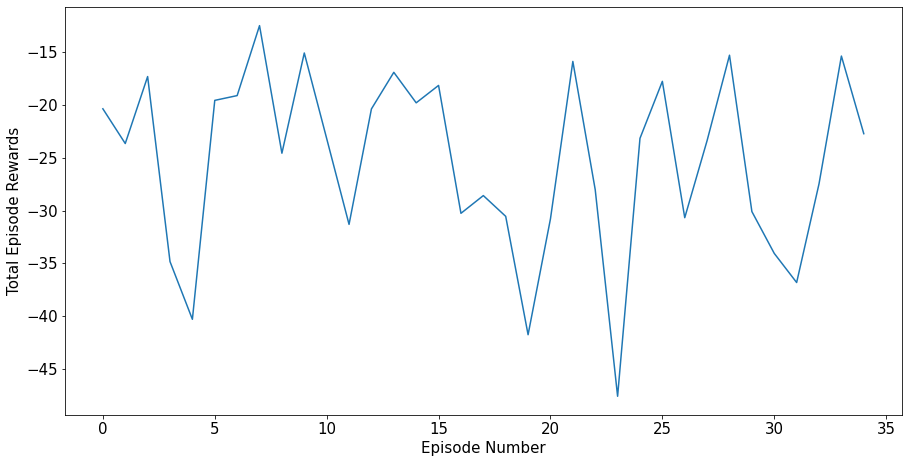

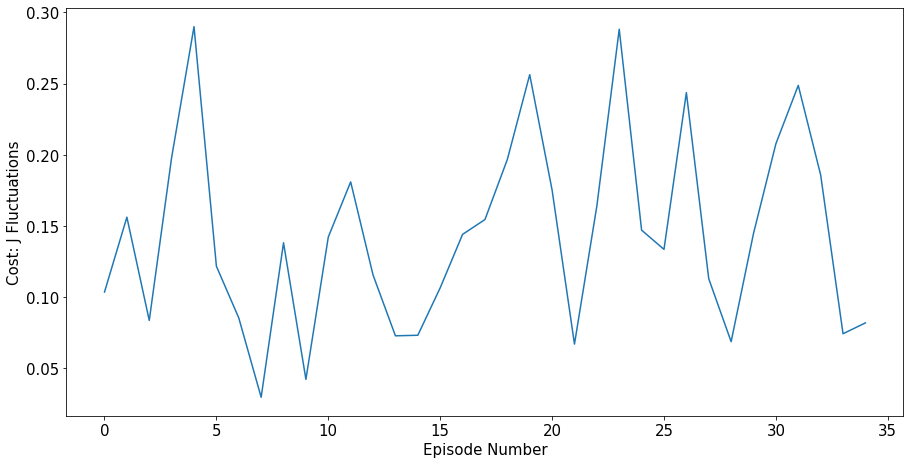

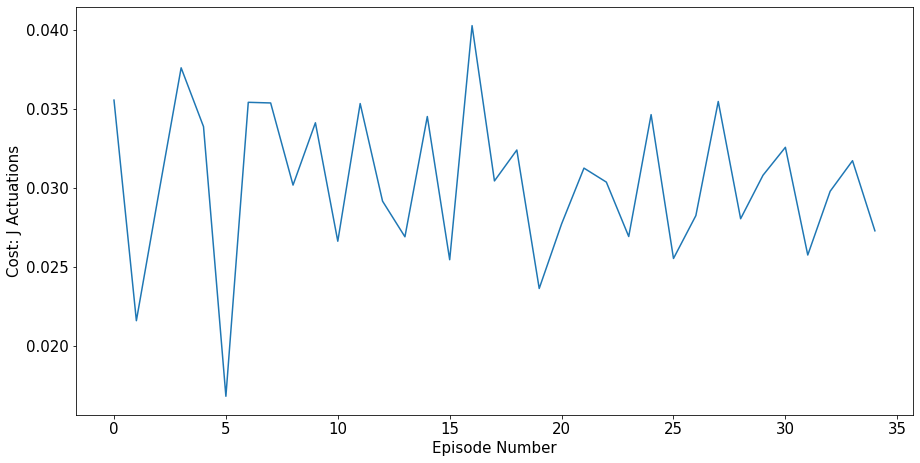

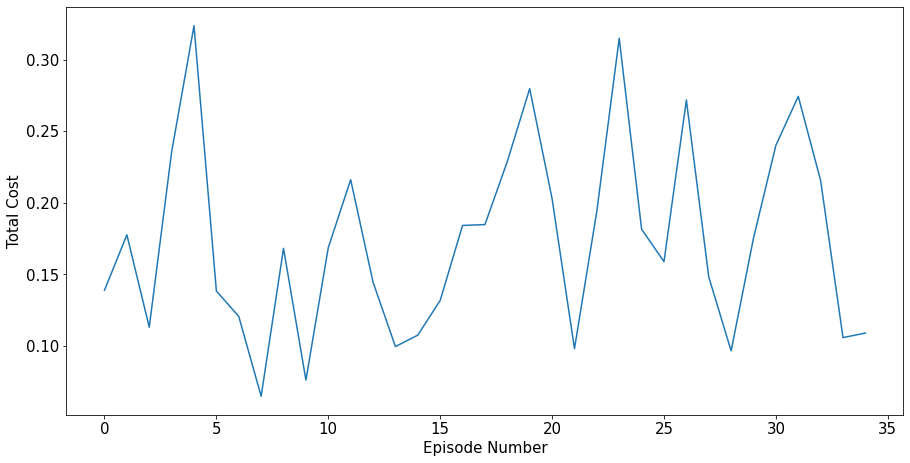

In [21]:
plot_regular(total_rewards,'Episode Number','Total Episode Rewards')
plot_regular(J_flucs,'Episode Number','Cost: J Fluctuations')
plot_regular(J_acts_scaled,'Episode Number','Cost: J Actuations')
plot_regular(J_tots,'Episode Number','Total Cost')

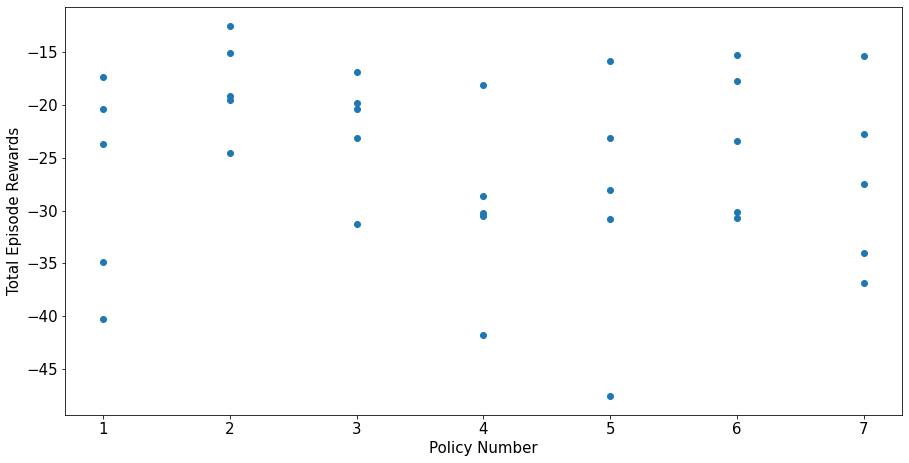

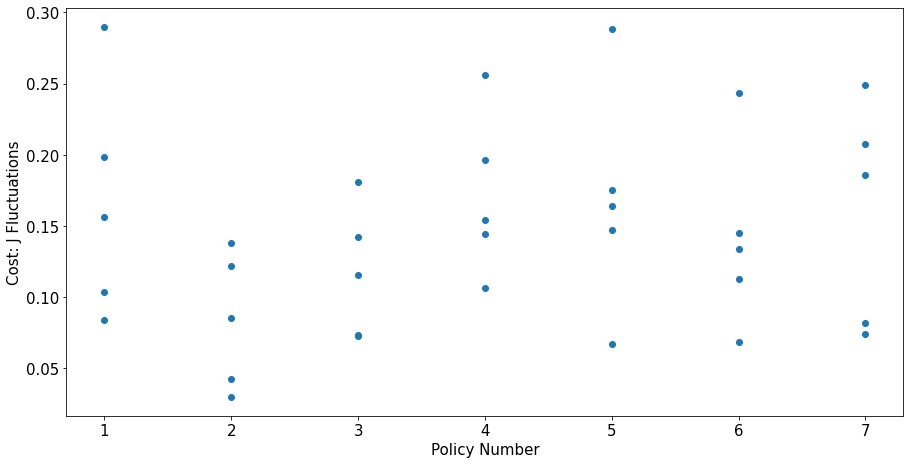

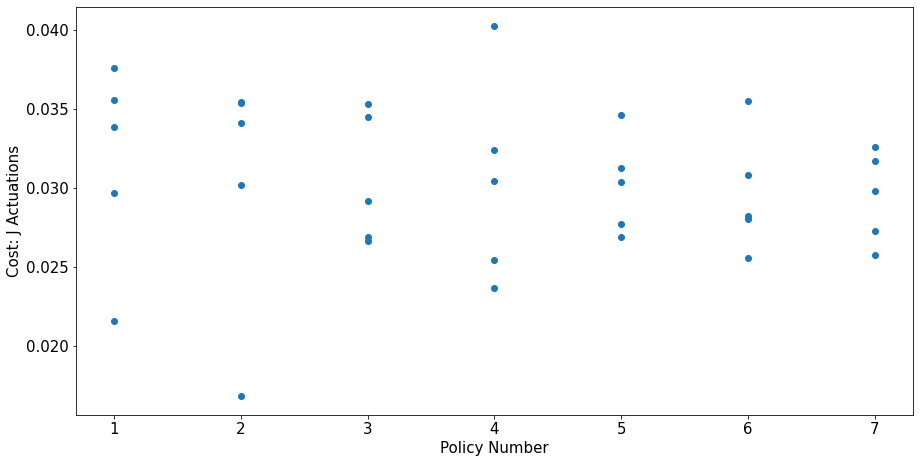

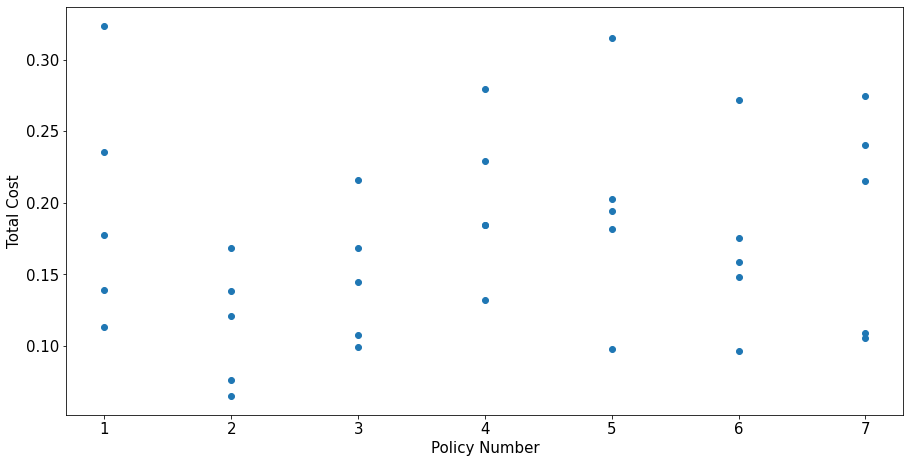

In [22]:
plot_policy_regular(total_rewards,'Policy Number','Total Episode Rewards',num_iterations)
plot_policy_regular(J_flucs,'Policy Number','Cost: J Fluctuations',num_iterations)
plot_policy_regular(J_acts_scaled,'Policy Number','Cost: J Actuations',num_iterations)
plot_policy_regular(J_tots,'Policy Number','Total Cost',num_iterations)

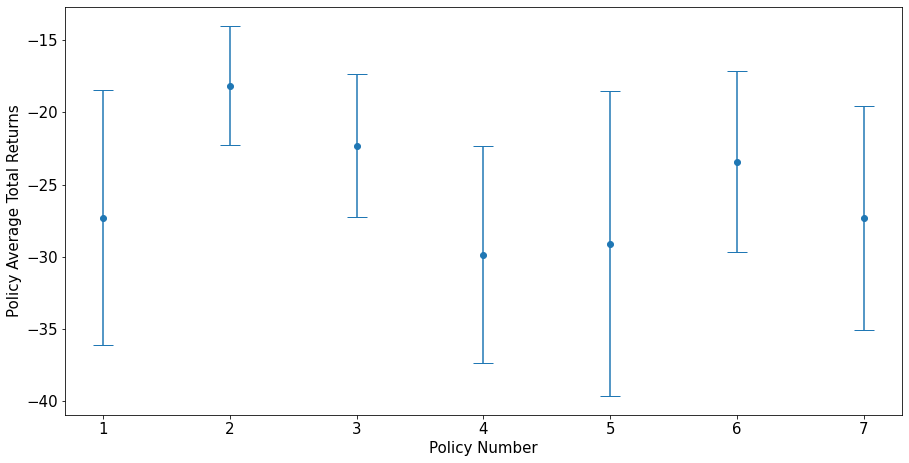

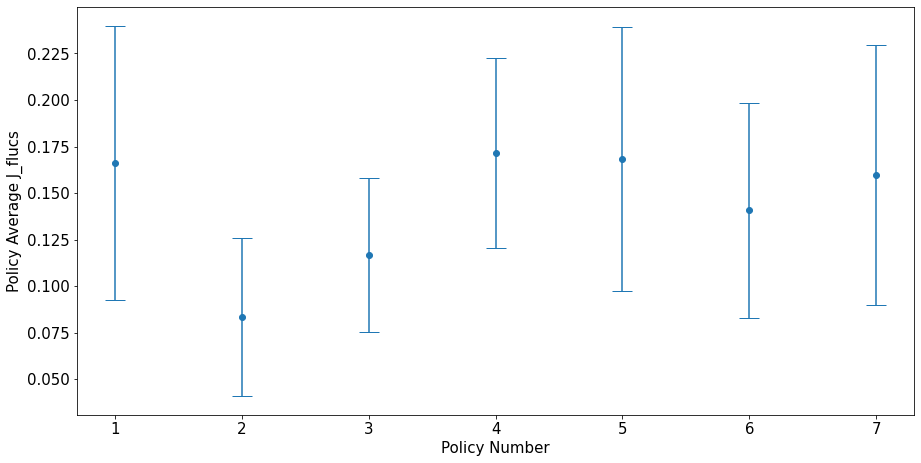

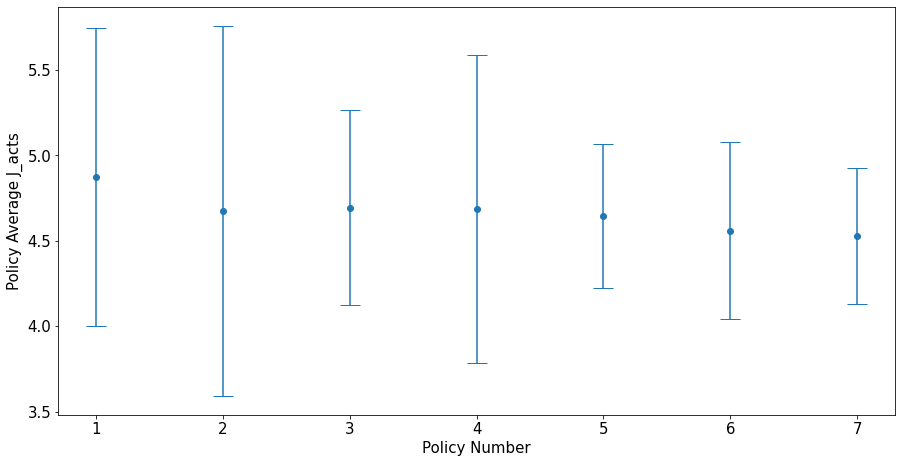

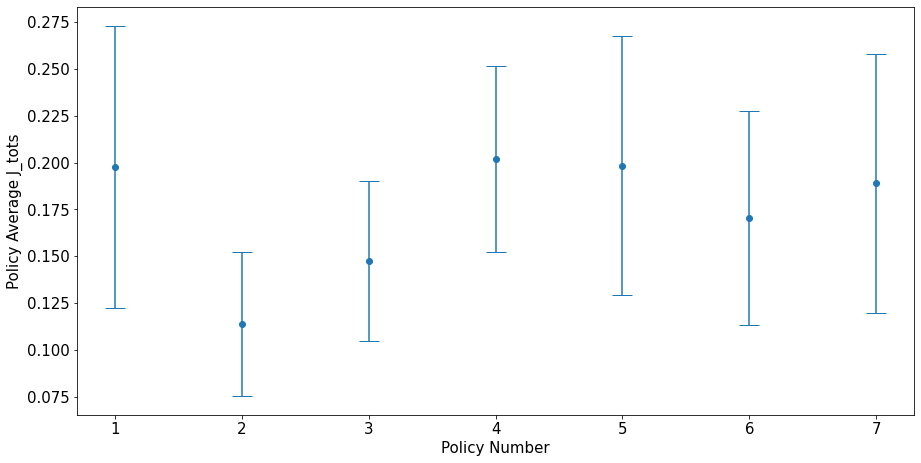

In [23]:
plot_policy_average(total_rewards,'Policy Number','Policy Average Total Returns',num_iterations)
plot_policy_average(J_flucs,'Policy Number','Policy Average J_flucs',num_iterations)
plot_policy_average(J_acts,'Policy Number','Policy Average J_acts',num_iterations)
plot_policy_average(J_tots,'Policy Number','Policy Average J_tots',num_iterations)

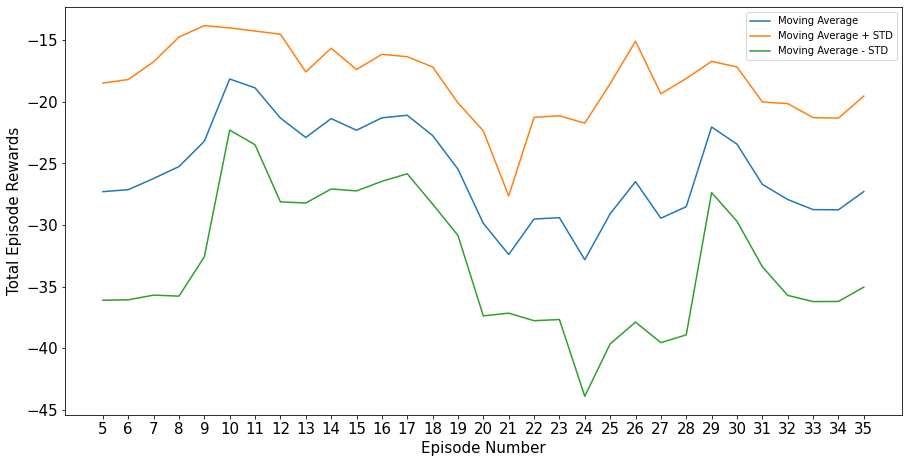

In [24]:
avg_sample=5
plot_moving_average_regular(total_rewards,'Episode Number','Total Episode Rewards',avg_sample)

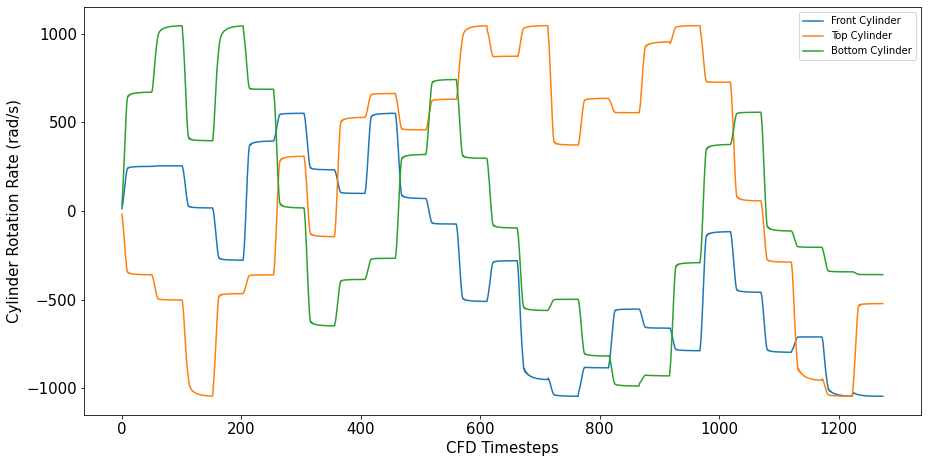

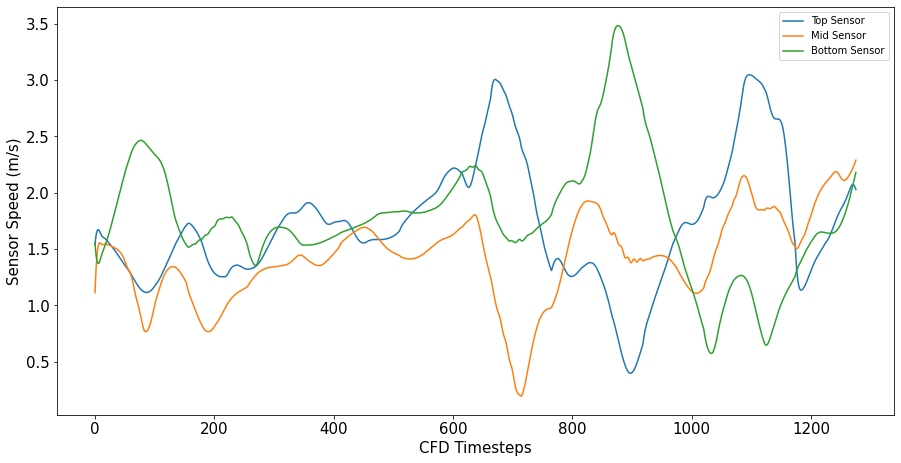

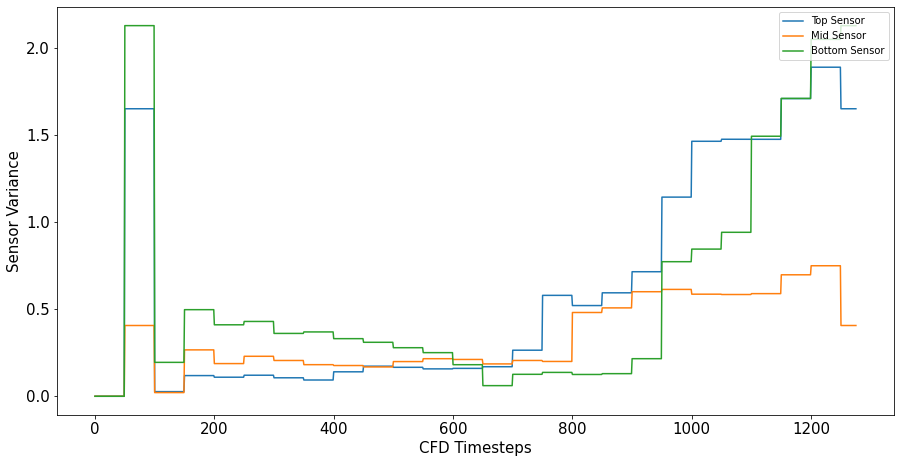

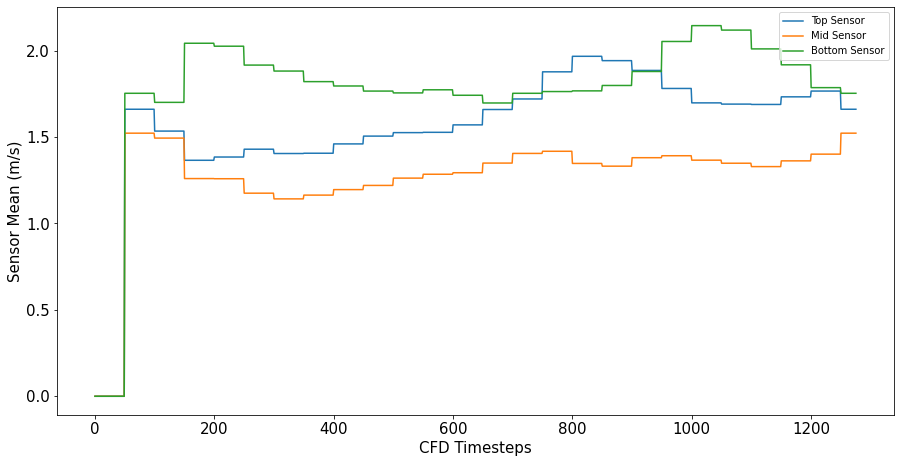

In [25]:
episode=33

front_cyl_data=master_data[episode-1]['front_cyl_RPS_PI']
top_cyl_data=master_data[episode-1]['top_cyl_RPS_PI']
bot_cyl_data=master_data[episode-1]['bot_cyl_RPS_PI']

top_sens_data=master_data[episode-1]['top_sens_values']
mid_sens_data=master_data[episode-1]['mid_sens_values']
bot_sens_data=master_data[episode-1]['bot_sens_values']

var_scaling=7.5
top_sens_var=calculate_episode_variance(top_sens_data,free_stream_vel,var_scaling,CFD_timesteps_period,
                                       CFD_timesteps_action,sampling_periods)
mid_sens_var=calculate_episode_variance(mid_sens_data,free_stream_vel,var_scaling,CFD_timesteps_period,
                                       CFD_timesteps_action,sampling_periods)
bot_sens_var=calculate_episode_variance(bot_sens_data,free_stream_vel,var_scaling,CFD_timesteps_period,
                                       CFD_timesteps_action,sampling_periods)

top_sens_mean=calculate_episode_mean(top_sens_data,CFD_timesteps_period,CFD_timesteps_action,sampling_periods)
mid_sens_mean=calculate_episode_mean(mid_sens_data,CFD_timesteps_period,CFD_timesteps_action,sampling_periods)
bot_sens_mean=calculate_episode_mean(bot_sens_data,CFD_timesteps_period,CFD_timesteps_action,sampling_periods)

plot_episode_cyl_data(front_cyl_data,top_cyl_data,bot_cyl_data)
plot_episode_sens_data(top_sens_data,mid_sens_data,bot_sens_data)
plot_episode_sens_variance(top_sens_var,mid_sens_var,bot_sens_var)
plot_episode_sens_mean(top_sens_mean,mid_sens_mean,bot_sens_mean)

In [26]:
print(master_data[episode-1]['values'])

[array([-2.9339945], dtype=float32), array([-2.9870892], dtype=float32), array([-3.8524847], dtype=float32), array([-3.620036], dtype=float32), array([-3.7827296], dtype=float32), array([-3.3445506], dtype=float32), array([-3.0745037], dtype=float32), array([-2.9959145], dtype=float32), array([-2.9440265], dtype=float32), array([-3.1511858], dtype=float32), array([-3.0787785], dtype=float32), array([-3.334992], dtype=float32), array([-3.2820177], dtype=float32), array([-3.1987944], dtype=float32), array([-3.8387203], dtype=float32), array([-3.7814023], dtype=float32), array([-4.025203], dtype=float32), array([-4.508936], dtype=float32), array([-5.849295], dtype=float32), array([-6.1638894], dtype=float32), array([-6.618067], dtype=float32), array([-7.412083], dtype=float32), array([-8.293425], dtype=float32), array([-8.71728], dtype=float32), array([-8.624982], dtype=float32)]
